<a href="https://colab.research.google.com/github/Harshit0208/Sentiment-Analysis/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading and importing packages

In [0]:
pip install wget

In [0]:
pip install pytreebank

In [0]:
pip install fasttext

In [0]:
pip install tqdm

In [0]:
import nltk
nltk.download('all')

In [36]:
import os
import sys
import wget
url="https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip"
wget.download(url,'/content')


'/content/trainDevTestTrees_PTB (1).zip'

### Transforming the data into tabular form

In [37]:
import pytreebank
out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst('./raw_data')
# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))
# Print the length of the training set
print(len(dataset['train']))
print(len(dataset['test']))
print(len(dataset['dev']))


8544
2210
1101


### Exploratory Data Analysis

In [38]:
import pandas as pd
# Read train data
df_train = pd.read_csv('/content/sst_train.txt', sep='\t', header=None, names=['truth', 'text'])
df_train['truth'] = df_train['truth'].str.replace('__label__', '')
df_train['truth'] = df_train['truth'].astype(int).astype('category')
df_train.head()

,truth,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...
2,4,Singer/composer Bryan Adams contributes a slew...
3,3,You 'd think by now America would have had eno...
4,4,Yet the act is still charming here .


In [39]:
import pandas as pd
# Read test data
df_test = pd.read_csv('/content/sst_test.txt', sep='\t', header=None, names=['truth', 'text'])
df_test['truth'] = df_test['truth'].str.replace('__label__', '')
df_test['truth'] = df_test['truth'].astype(int).astype('category')
df_test.head()

,truth,text
0,3,Effective but too-tepid biopic
1,4,If you sometimes like to go to the movies to h...
2,5,"Emerges as something rare , an issue movie tha..."
3,3,The film provides some great insight into the ...
4,5,Offers that rare combination of entertainment ...


In [0]:
import pandas as pd
# Read val data
df_dev = pd.read_csv('/content/sst_dev.txt', sep='\t', header=None, names=['truth', 'text'])
df_dev['truth'] = df_dev['truth'].str.replace('__label__', '')
df_dev['truth'] = df_dev['truth'].astype(int).astype('category')


Text(0, 0.5, 'Label')

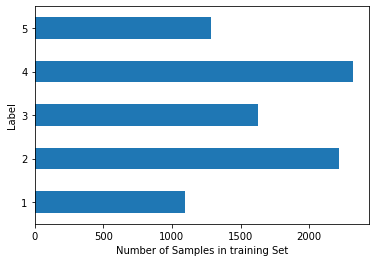

In [14]:
import matplotlib.pyplot as plt

ax=df_train['truth'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

Text(0, 0.5, 'Label')

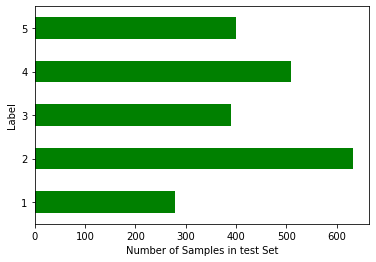

In [15]:
import matplotlib.pyplot as plt

ax=df_test['truth'].value_counts(sort=False).plot(kind='barh',color='green')
ax.set_xlabel("Number of Samples in test Set")
ax.set_ylabel("Label")

In [17]:
df_train['len']=df_train['text'].str.len()
df_train=df_train.sort_values(['len'],ascending=True)
df_train.head(10)

,truth,text,len
593,3,Go .,4
8484,3,Eh .,4
4198,4,Wow .,5
5286,4,Yes .,5
5288,2,No. .,5
1270,2,Why ?,5
7670,4,Zoom !,6
7669,3,Bang !,6
2038,3,A. . .,6
335,4,Cool .,6


In [0]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import fasttext
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from tqdm.auto import tqdm


In [0]:
def print_accuracy(df, pred_column):
    "Print f1 score and accuracy after making predictions"
    f1_macro = f1_score(df['truth'], df[pred_column], average='macro')
    acc = accuracy_score(df['truth'], df[pred_column])*100
    return f1_macro, acc

### 1. TextBlob

In [0]:
def textblob_score(sentence):
    return TextBlob(sentence).sentiment.polarity

In [42]:
df=df_test# Convert textblob sentiment score
df['textblob_score'] = df['text'].apply(textblob_score)
# Convert float score to category based on binning
df['textblob_pred'] = pd.cut(df['textblob_score'], bins=5, labels=[1, 2, 3, 4, 5])
df = df.drop('textblob_score', axis=1)
df.head()

,truth,text,textblob_pred
0,3,Effective but too-tepid biopic,4
1,4,If you sometimes like to go to the movies to h...,4
2,5,"Emerges as something rare , an issue movie tha...",4
3,3,The film provides some great insight into the ...,4
4,5,Offers that rare combination of entertainment ...,3


In [23]:
acc = print_accuracy(df, 'textblob_pred')
print("Macro F1-score: {}\nAccuracy: {}".format(acc[0], acc[1]))

Macro F1-score: 0.2468141571266554
Accuracy: 28.3710407239819


### 2.VADER

In [0]:
vader = SentimentIntensityAnalyzer()
def score_vader(sentence, vader):
    return vader.polarity_scores(sentence)['compound']

In [28]:
# Calculate Vader sentiment score
df['vader_score'] = df['text'].apply(lambda x: score_vader(x, vader))
# Convert float score to category based on binning
df['vader_pred'] = pd.cut(df['vader_score'], bins=5, labels=[1, 2, 3, 4, 5])
df = df.drop('vader_score', axis=1)
df.head()

,truth,text,textblob_pred,vader_pred
0,3,Effective but too-tepid biopic,4,4
1,4,If you sometimes like to go to the movies to h...,4,5
2,5,"Emerges as something rare , an issue movie tha...",4,5
3,3,The film provides some great insight into the ...,4,5
4,5,Offers that rare combination of entertainment ...,3,4


In [29]:
acc = print_accuracy(df, 'vader_pred')
print("Macro F1-score: {}\nAccuracy: {}".format(acc[0], acc[1]))

Macro F1-score: 0.31297326018199634
Accuracy: 31.538461538461537


### 3.FastText

In [0]:
hyper_params = {
    "lr": 0.5,
    "epoch": 100,
    "wordNgrams": 3,
    "dim": 100,
    "ws": 3,
}

In [0]:
model = fasttext.train_supervised(input="/content/sst_train.txt", **hyper_params)
model.save_model('/content/fast.bin')

In [64]:
print(model.labels)

['__label__4', '__label__2', '__label__3', '__label__5', '__label__1']


In [109]:
ft_model = fasttext.load_model('/content/fast.bin')
list_text=df['text'].tolist()
labels=ft_model.predict(list_text)
label = [''.join(i) for i in labels[0]]
dfg=pd.Series(label)
df['fasttext_pred'] = dfg.str.replace('__label__', '')
df['fasttext_pred'] = df['fasttext_pred'].astype(int).astype('category')
acc = print_accuracy(df, 'fasttext_pred')
print("Macro F1-score: {}\nAccuracy: {}".format(acc[0], acc[1]))

Macro F1-score: 0.3658513395809423
Accuracy: 39.366515837104075
